# <center>Modelos de difusión</center>

In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll
import torch
import torch.nn as nn
import torch.optim as optim

### Datos de entrenamiento

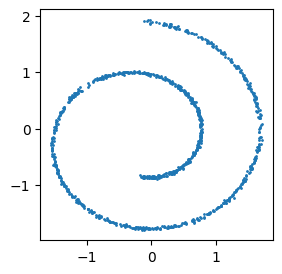

In [ ]:
def get_batch(batch_size=1000, noise=0.1):
    x, _ = make_swiss_roll(batch_size, noise=noise)
    x = x[:, [0, 2]]
    x = (x - x.mean()) / x.std()
    return torch.tensor(x).float()

# Ejemplo:
samples = get_batch()
plt.figure(figsize=(3, 3))
plt.scatter(samples[:, 0], samples[:, 1], s=1)
plt.show()

### Ejemplo proceso forward y backward

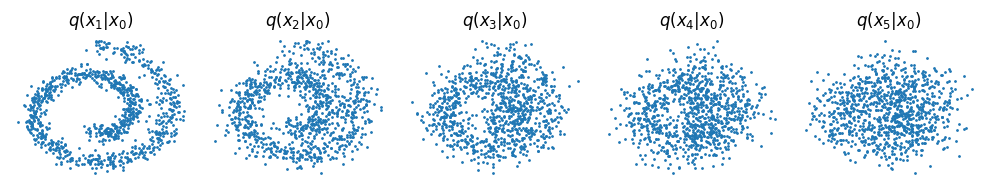

In [ ]:
# Hiperparámetros de difusión:

T = 5
alpha = torch.linspace(1, 0.9, T + 1)
alpha_bar = torch.cumprod(alpha, dim=0)

def add_noise(x_0, t):
    epsilon = torch.randn_like(x_0)
    x_t = alpha_bar[t].sqrt() * x_0 + (1 - alpha_bar[t]).sqrt() * epsilon
    return x_t

# Ejemplo:
x_0 = get_batch()

plt.figure(figsize=(10, 2))
for t in range(1, T + 1):
    x_t = add_noise(x_0, t)
    plt.subplot(1, T, t)
    plt.scatter(x_t[:, 0], x_t[:, 1], s=1)
    plt.title(f'$q(x_{t}|x_0)$')
    plt.axis('off')

plt.tight_layout()
plt.show()

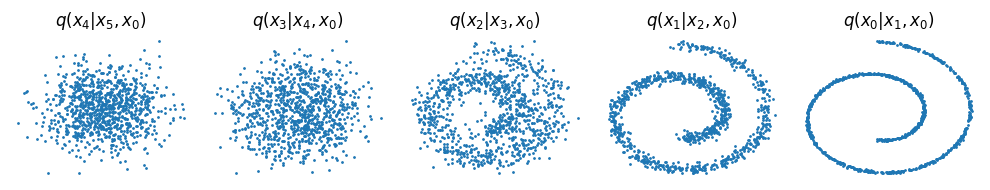

In [ ]:
def conditional_denoising(x_t, t, x_0):
    
    # Media:
    factor1 = alpha_bar[t-1].sqrt() * (1 - alpha[t]) / (1 - alpha_bar[t])
    factor2 = alpha[t].sqrt() * (1 - alpha_bar[t-1]) / (1 - alpha_bar[t])
    mu_q = factor1 * x_0 + factor2 * x_t

    # Varianza:
    sigma2_q = (1 - alpha[t]) * (1 - alpha_bar[t-1]) / (1 - alpha_bar[t])

    # Generación:
    epsilon = torch.rand_like(x_0)
    x_prev = mu_q + sigma2_q.sqrt() * epsilon

    return x_prev

# Ejemplo:

x_0 = get_batch()
x_t = torch.randn_like(x_0)  # muestra desde p(x_T) ≈ q(x_T).

plt.figure(figsize=(10, 2))
for t in reversed(range(1, T + 1)):
    plt.subplot(1, T, T - t + 1)
    x_t = conditional_denoising(x_t, t, x_0)  # muestra desde q(x_{t-1}|x_t,x_0).
    plt.scatter(x_t[:, 0], x_t[:, 1], s=1)
    plt.title(f'$q(x_{t-1}|x_{t},x_0)$')
    plt.axis('off')

plt.tight_layout()
plt.show()

### Clase DM

In [5]:
class DM:
    '''Modelo de difusión DDPM.'''

    def __init__(self, model, T=5, initial_alpha=1, final_alpha=0.95):
        '''
        Inicializa un modelo de difusión con (alpha_t)_{t=1}^T una lista equiespaciada
        del intervalo [initial_alpha, final_alpha].

        Args:
        - model (nn.Module): red neuronal para el denoising (predice mu_q).
        - T (int): cantidad de pasos de difusión.
        - initial_alpha (float): valor de alpha[0].
        - final_alpha (float): valor de alpha[T].
        '''

        self.model = model
        self.T = T
        self.alpha = torch.linspace(initial_alpha, final_alpha, T + 1).unsqueeze(1)  # size: [T+1, 1].
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)  # size: [T+1, 1].


    def mu_q(self, x_0, x_t, t):
        '''
        Calcula las medias mu_q(x_0,x_t,t) del proceso reverso condicional q(x_{t-1}|x_t,x_0) para
        un batch de muestras.

        Args:
        - x_0 (torch.Tensor[batch_size, data_dim]): batch inicial desde q(x_0) = p_true(x_0).
        - x_t (torch.Tensor[batch_size, data_dim]): batch desde q(x_t|x_0).
        - t (torch.Tensor[batch_size]): batch de tiempos en el conjunto {1,...,T}.

        Returns:
        - mu_q (torch.Tensor [batch_size, data_dim]): batch de medias de q(x_{t-1}|x_t,x_0).
        '''

        factor1 = self.alpha_bar[t-1].sqrt() * (1 - self.alpha[t]) / (1 - self.alpha_bar[t])
        factor2 = self.alpha[t].sqrt() * (1 - self.alpha_bar[t-1]) / (1 - self.alpha_bar[t])
        mu_q = factor1 * x_0 + factor2 * x_t
        return mu_q


    def sigma2_q(self, t):
        '''
        Calcula las varianzas sigma2_q(t) del proceso reverso condicional q(x_{t-1}|x_t,x_0) para
        un batch de muestras.

        Args:
        - t (torch.Tensor[batch_size]): batch de tiempos en el conjunto {1,...,T}.

        Returns:
        - sigma2_q (torch.Tensor[batch_size, data_dim]): batch de varianzas de q(x_{t-1}|x_t,x_0).
        '''

        sigma2_q = (1 - self.alpha[t]) * (1 - self.alpha_bar[t-1]) / (1 - self.alpha_bar[t])
        return sigma2_q


    def train(self, optimizer, iters=5000, batch_fn=get_batch):
        '''
        Se entrena el modelo de difusión sobre un conjunto de datos obtenidos a partir
        de una función generadora de batches.

        Args:
        - optimizer (optim.Optimizer): optimizador para la red self.model.
        - iters (int): cantidad de iteraciones de entrenamiento (actualizaciones de parámetros).
        - batch_fn (callable): función con la que se obtienen batches de datos de tamaño [batch_size, data_dim].
        '''

        for _ in range(iters):

            x_0 = batch_fn()
            t = torch.randint(1, self.T + 1, size=[len(x_0)])

            # Inyección de ruido:
            x_t = self.alpha_bar[t].sqrt() * x_0 + (1-self.alpha_bar[t]).sqrt() * torch.randn_like(x_0)

            # Error cuadrático medio:
            loss = (self.model(x_t, t) - self.mu_q(x_0, x_t, t)).norm(dim=-1) ** 2
            loss = loss.mean()

            # Optimización:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    

    def generate_samples(self, n_samples, data_dim=2):
        '''
        Genera muestras a partir del modelo de difusión ya entrenado iterando el proceso reverso.

        Args:
        - n_samples (int): cantidad de muestras a generar.
        - data_dim (int): dimensión de los datos.

        Returns:
        - x_t (torch.Tensor[n_samples, data_dim]): batch generado a partir de p(x_0) ≈ q(x_0) = p_true(x_0).
        '''

        x_t = torch.randn(n_samples, data_dim)
        
        for t in reversed(range(1, self.T + 1)):
            t_batch = t * torch.ones(n_samples).long()

            mu_theta = self.model(x_t, t_batch)
            sigma_q = self.sigma2_q(t).sqrt()

            x_t = mu_theta + sigma_q * torch.randn_like(x_t)

        return x_t.detach()

### Red neuronal

In [6]:
class DiffusionNetwork(nn.Module):
    '''Red neuronal para el modelo de difusión.'''

    def __init__(self, data_dim=2, hidden_dim=128):
        '''
        Inicializa una red fully connected de 4 capas.

        Args:
        - data_dim (int): dimensión de los datos.
        - hidden_dim (int): dimensión oculta de la red neuronal.
        '''
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(data_dim + 1, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, data_dim)
        )

    def forward(self, x_t, t):
        '''
        Calcula la media del proceso reverso p(x_{t-1}|x_t). La entrada es un batch de vectores
        con los respectivos tiempos t asociado a cada vector. La salida es un batch
        de vectores de la misma dimensión que los vectores de la entrada.

        Args:
        - x_t (torch.Tensor[batch_size, data_dim]): batch de muestras desde q(x_t).
        - t (torch.Tensor[batch_size]): batch de tiempos en el conjunto {1,...,T}.

        Returns:
        - mu_theta (torch.Tensor[batch_size, data_dim]): batch de medias de p(x_{t-1}|x_t).
        '''

        input = torch.cat([x_t, t.unsqueeze(1)], dim=1)
        mu_theta = self.model(input)
        return mu_theta

### Entrenamiento

In [7]:
# Entrenamiento:

model = DiffusionNetwork()
dm = DM(model)

optimizer = optim.AdamW(model.parameters())
dm.train(optimizer, iters=5000)

### Generación

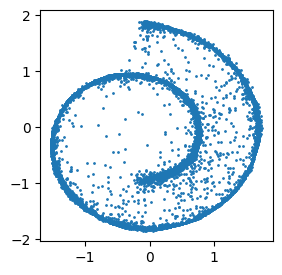

In [ ]:
# Generación:

samples = dm.generate_samples(n_samples=10000)
plt.figure(figsize=(3, 3))
plt.scatter(samples[:, 0], samples[:, 1], s=1)
plt.show()

### Guidance

In [9]:
class GuidanceDM(DM):

    def generate_samples(self, n_samples, data_dim=2, y=None, discriminator_grad_fn=None, scale=1):
        '''
        Genera muestras a partir del modelo de difusión ya entrenado iterando el proceso reverso. También
        se puede generar una muestra condicional p(x_0|y) usando guidance.

        Args:
        - n_samples (int): cantidad de muestras a generar.
        - data_dim (int): dimensión de los datos.
        - y (object): condición que recibirá el modelo discriminador.
        - discriminator_grad_fn (callable): función que retorna el gradiente nabla_{x_t}[log p(y|x_t)].
        - scale (float): escala de guidance.

        Returns:
        - x_t (torch.Tensor[n_samples, data_dim]): batch generado a partir de p(x_0) ≈ q(x_0) = p_true(x_0) en
        el caso incondicional y de p(x_0|y) ≈ q(x_0|y) = p_true(x_0|y) en el caso condicional.
        '''

        x_t = torch.randn(n_samples, data_dim)
        
        for t in reversed(range(1, self.T + 1)):
            t_batch = t * torch.ones(n_samples).long()

            mu_theta = self.model(x_t, t_batch)
            sigma_q = self.sigma2_q(t).sqrt()

            if y is not None:
                discriminator_grad = discriminator_grad_fn(x_t, y)
                factor = (1 - self.alpha[t]) / self.alpha[t].sqrt()  # creciente en t -> scale dinámico.
                mu_theta = mu_theta + scale * (factor * discriminator_grad)

            x_t = mu_theta + sigma_q * torch.randn_like(x_t)

        return x_t.detach()

In [10]:
def position_discriminator(x, y):
    '''
    Función que retorna el score de q(y|x), el cual será modelado como la distancia, coordenada a coordenada, de x a el centro y. 
    '''

    y = torch.tensor(y).unsqueeze(0)
    discriminator_grad = (y - x) / 2
    return discriminator_grad

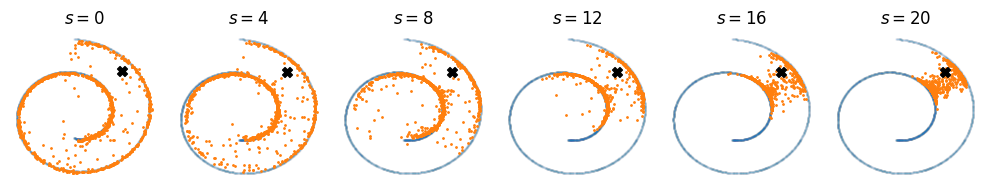

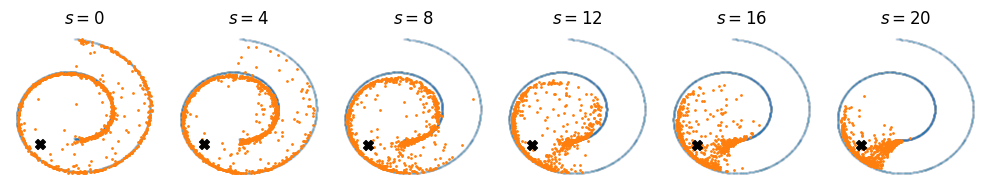

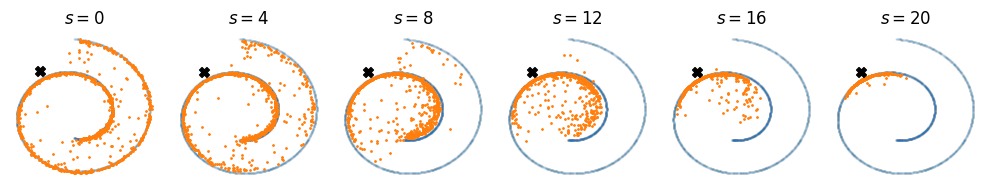

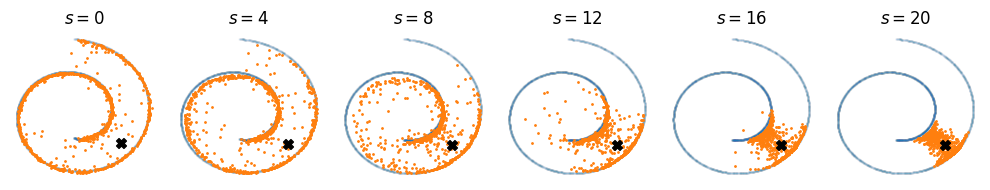

In [ ]:
# Generación condicional:

conditional_dm = GuidanceDM(model)

true_data = get_batch(10000, noise=0)
scales = range(0, 21, 4)

for center in ([1, 1], [-1, -1], [-1, 1], [1, -1]):

    plt.figure(figsize=(10, 2))

    for idx, s in enumerate(scales):

        samples = conditional_dm.generate_samples(n_samples=1000, data_dim=2, y=center, discriminator_grad_fn=position_discriminator, scale=s)

        plt.subplot(1, len(scales), idx+1)
        plt.scatter(true_data[:, 0], true_data[:, 1], s=1, alpha=0.01)
        plt.scatter(samples[:, 0], samples[:, 1], s=1)
        plt.scatter(*center, s=50, c='k', marker='X')
        plt.title(f'$s={s}$')
        plt.axis('off')
    plt.tight_layout()
    plt.show()